In [23]:
import datetime
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['figure.figsize'] = 20, 4
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train = pd.read_csv('train_modified/train_modified.csv')

In [3]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 51 columns):
Disbursed                        87020 non-null float64
Existing_EMI                     87020 non-null float64
ID                               87020 non-null object
Loan_Amount_Applied              87020 non-null float64
Loan_Tenure_Applied              87020 non-null float64
Monthly_Income                   87020 non-null int64
Var4                             87020 non-null int64
Var5                             87020 non-null int64
Age                              87020 non-null int64
EMI_Loan_Submitted_Missing       87020 non-null int64
Interest_Rate_Missing            87020 non-null int64
Loan_Amount_Submitted_Missing    87020 non-null int64
Loan_Tenure_Submitted_Missing    87020 non-null int64
Processing_Fee_Missing           87020 non-null int64
Device_Type_0                    87020 non-null float64
Device_Type_1                    87020 non-null float64
Filled_Form_0 

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
target = 'Disbursed'
IDcol = 'ID'

In [6]:
train[target].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [20]:
def model_fit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    alg.fit(dtrain[predictors], dtrain[target])
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='roc_auc')
        
    print('\n Model Report')
    print('Accuracy: %.4g' % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print('AUC Score(Train): %f' % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    if performCV:
        print('CV Score: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g' % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances', figsize=(15, 4))
        plt.ylabel('Feature Importance Score')


 Model Report
Accuracy: 0.9856
AUC Score(Train): 0.862264
CV Score: Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


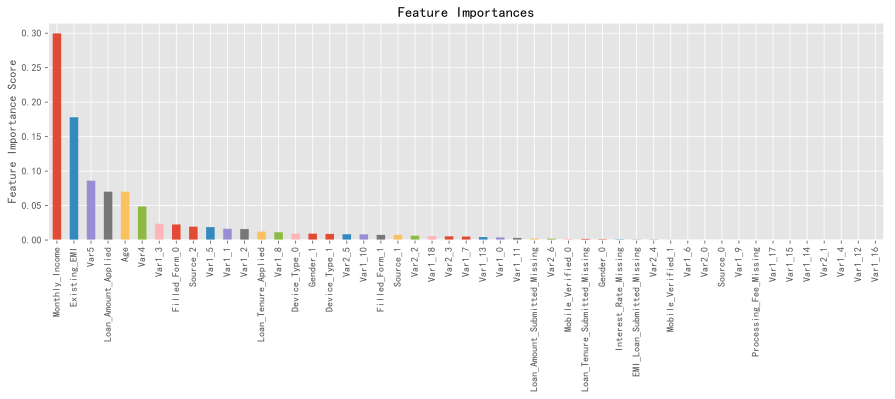

In [21]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
model_fit(gbm0, train, predictors)

In [24]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(20, 81, 10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                                                               max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
gsearch1.grid_scores_ , gsearch1.best_params_, gsearch1.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83337, std: 0.00991, params: {'n_estimators': 20},
  mean: 0.83697, std: 0.00994, params: {'n_estimators': 30},
  mean: 0.83832, std: 0.01050, params: {'n_estimators': 40},
  mean: 0.83867, std: 0.01081, params: {'n_estimators': 50},
  mean: 0.83939, std: 0.01077, params: {'n_estimators': 60},
  mean: 0.83891, std: 0.01044, params: {'n_estimators': 70},
  mean: 0.83807, std: 0.01093, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.8393880266861308)

In [31]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83297, std: 0.01226, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.83251, std: 0.01054, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.83386, std: 0.01415, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.83379, std: 0.01169, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.83339, std: 0.01266, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.83365, std: 0.00787, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.83663, std: 0.00991, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.83480, std: 0.00828, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.83786, std: 0.01067, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.83769, std: 0.01060, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.83581, std: 0.01003, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.83729, std: 0.00959, params: {'max_depth': 9, 'min_samples_split': 400},
  

In [33]:
param_test3 = {'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                                max_features='sqrt', subsample=0.8, random_state=10, max_depth=9, min_samples_split=800), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=800,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': range(30, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83821, std: 0.01128, params: {'min_samples_leaf': 30},
  mean: 0.83701, std: 0.01214, params: {'min_samples_leaf': 40},
  mean: 0.83670, std: 0.01234, params: {'min_samples_leaf': 50},
  mean: 0.83540, std: 0.01209, params: {'min_samples_leaf': 60},
  mean: 0.83623, std: 0.01187, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 30},
 0.8382128706279215)


 Model Report
Accuracy: 0.9854
AUC Score(Train): 0.904815
CV Score: Mean - 0.8382129 | Std - 0.0112821 | Min - 0.821965 | Max - 0.8545785


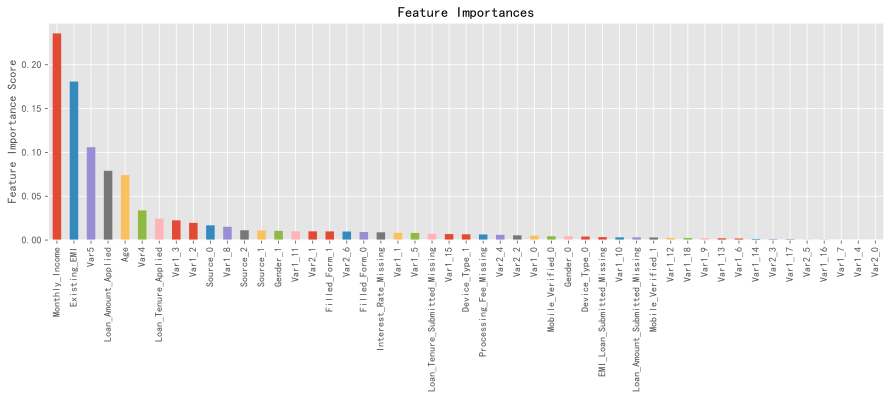

In [35]:
model_fit(gsearch2.best_estimator_, train, predictors)

In [38]:
param_test4 = {'max_features':range(3,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=800, min_samples_leaf=30, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samples_split=800,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': range(3, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83112, std: 0.01224, params: {'max_features': 3},
  mean: 0.83660, std: 0.01121, params: {'max_features': 5},
  mean: 0.83821, std: 0.01128, params: {'max_features': 7},
  mean: 0.83690, std: 0.00862, params: {'max_features': 9},
  mean: 0.83743, std: 0.01055, params: {'max_features': 11},
  mean: 0.83746, std: 0.01117, params: {'max_features': 13},
  mean: 0.83850, std: 0.00771, params: {'max_features': 15},
  mean: 0.83588, std: 0.00925, params: {'max_features': 17},
  mean: 0.83483, std: 0.00940, params: {'max_features': 19}],
 {'max_features': 15},
 0.8385048799744805)

In [40]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=800, min_samples_leaf=30, random_state=10, max_features=15),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=15, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samples_split=800,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83456, std: 0.01083, params: {'subsample': 0.6},
  mean: 0.83544, std: 0.00921, params: {'subsample': 0.7},
  mean: 0.83614, std: 0.01086, params: {'subsample': 0.75},
  mean: 0.83850, std: 0.00771, params: {'subsample': 0.8},
  mean: 0.83520, std: 0.01135, params: {'subsample': 0.85},
  mean: 0.83470, std: 0.00976, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.8385048799744805)


 Model Report
Accuracy: 0.9854
AUC Score(Train): 0.913939
CV Score: Mean - 0.8391564 | Std - 0.009142412 | Min - 0.8303877 | Max - 0.8516887


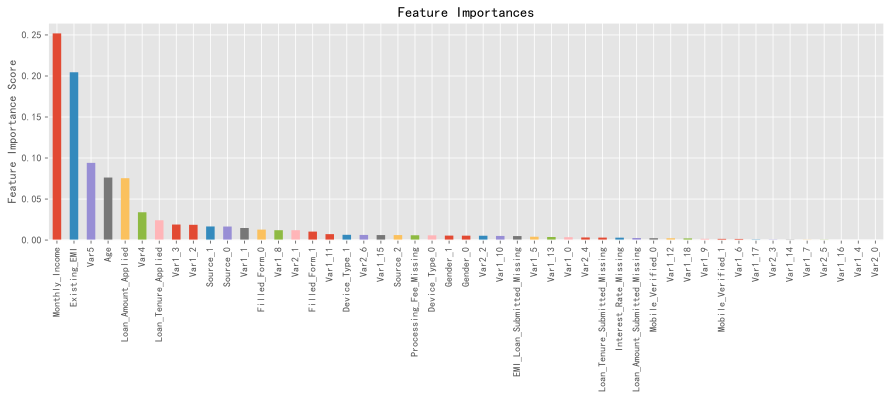

In [45]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=9, min_samples_split=800, 
                                         min_samples_leaf=30, subsample=0.8, random_state=10, max_features=15)
model_fit(gbm_tuned_1, train, predictors)


 Model Report
Accuracy: 0.9854
AUC Score(Train): 0.918244
CV Score: Mean - 0.8401438 | Std - 0.009017546 | Min - 0.8291171 | Max - 0.8512282


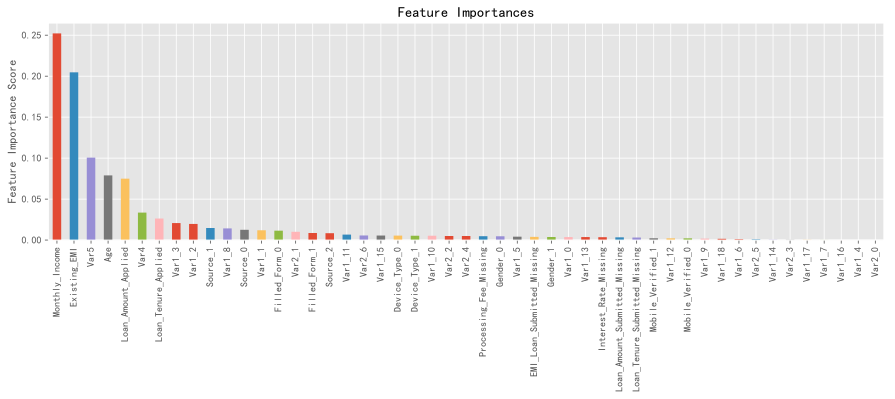

In [48]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=800, 
                                         min_samples_leaf=30, subsample=0.8, random_state=10, max_features=15)
model_fit(gbm_tuned_2, train, predictors)